<a href="https://colab.research.google.com/github/rajashekar/colab/blob/main/Transliterate_plain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [55]:
import pandas as pd
import numpy as np

from keras.models import Model, load_model
from keras.layers import Input, LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint

import tensorflow as tf
import tensorflow.keras.backend as K

import matplotlib.pyplot as plt

In [56]:
!nvidia-smi

Mon Oct  4 13:45:33 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P0    44W / 250W |   4625MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [57]:
%cd /content/drive/MyDrive/Colab/Transliterate/

/content/drive/MyDrive/Colab/Transliterate


In [58]:
%ls

affidavits.csv                 model_plot_dec.png
hi.translit.sampled.test.tsv   model.png
hi.translit.sampled.train.tsv  model_v1.h5
manual_saved_model.h5          players_with_hindi_names.json
model.h5                       Transliterate_v2.ipynb


# Preprocessing Data

## load affidavits dataset


In [59]:
affidavits_df = pd.read_csv('affidavits.csv')

In [60]:
affidavits_df.head()

,address,affidavit_filename_with_unique_id,age,application_uploaded,assembly_constituency,current_status,dropdown_value,fathers_or_husbands_name_english,fathers_or_husbands_name_hindi,name,name_english,name_hindi,party_name,photo_filename_with_unique_id,photo_url,state,unique_id,url
0,"O/5, BANKIM MUKHERJEE SARANI, DURGAPUR COLONY,...",NaN,57,"7th April, 2021",Rashbehari,NaN,NaN,LATE SUBODH CHANDRA DAS,प्रयात सुबोध चन्द्र दास,SWAPAN DAS,SWAPAN DAS,स्वपन दास,Bahujan Mukti Party,NaN,NaN,West Bengal,1,NaN
1,"F-301, PRANTIK PALLY, KOLKATA – 700042",NaN,41,"7th April, 2021",Rashbehari,NaN,NaN,LATE PINAKI KUNDU,स्वर्गीय पिनाकि कुंडू,PREETAM KUNDU,PREETAM KUNDU,प्रीतम कुंडू,Independent,NaN,NaN,West Bengal,2,NaN
2,"Vill- Debidaspur, P.O.- Kankuria, P.S.- Samser...",NaN,60,"26th April, 2021",Samserganj,NaN,NaN,Late Nur Mohammad Biswas,मृत नूर महम्मद बिश्वास,Zaidur Rahaman,Zaidur Rahaman,जैदुर रहमान,Indian National Congress,NaN,NaN,West Bengal,3,NaN
3,"F-301, PRANTIK PALLY, KOLKATA – 700042",NaN,41,"7th April, 2021",Rashbehari,NaN,NaN,LATE PINAKI KUNDU,स्वर्गीय पिनाकि कुंडू,PREETAM KUNDU,PREETAM KUNDU,प्रीतम कुंडू,Independent,NaN,NaN,West Bengal,4,NaN
4,"VILL-FULBARI, P.O-KAMLABARI, P.S-ENGLISH BAZAR...",NaN,42,"6th April, 2021",Manikchak,NaN,NaN,LT. ALI MOHAMMAD,स्वर्गीय आली महममद,ALAM MOTTAKIN,ALAM MOTTAKIN,आलम मोत्ताकिन,Indian National Congress,NaN,NaN,West Bengal,5,NaN


In [61]:
af_df = affidavits_df[['fathers_or_husbands_name_hindi', 'fathers_or_husbands_name_english', 'name_hindi', 'name_english']]

In [62]:
# split and merge
input_target_df = pd.concat([
                    af_df[['fathers_or_husbands_name_hindi','fathers_or_husbands_name_english']].rename(columns={"fathers_or_husbands_name_hindi": "hindi", "fathers_or_husbands_name_english": "english"}), 
                    af_df[['name_hindi','name_english']].rename(columns={"name_hindi": "hindi", "name_english": "english"})
                  ], ignore_index=True)

In [63]:
input_target_df.head()

,hindi,english
0,प्रयात सुबोध चन्द्र दास,LATE SUBODH CHANDRA DAS
1,स्वर्गीय पिनाकि कुंडू,LATE PINAKI KUNDU
2,मृत नूर महम्मद बिश्वास,Late Nur Mohammad Biswas
3,स्वर्गीय पिनाकि कुंडू,LATE PINAKI KUNDU
4,स्वर्गीय आली महममद,LT. ALI MOHAMMAD


## load cricket dataset

In [64]:
cricket_df = pd.read_json('players_with_hindi_names.json')

In [65]:
cricket_df.head()

,id,hindi_name,hindi_long_name,english_name,gender,date_of_birth,country_id,slug
0,90143,आर गुरबाज़,रहमानउल्लाह गुरबाज़,Rahmanullah Gurbaz,M,"{'year': 2001, 'month': 11, 'date': 28}",40,rahmanullah-gurbaz
1,54018,एम रिज़वान,मोहम्मद रिज़वान,Mohammad Rizwan,M,"{'year': 1992, 'month': 6, 'date': 1}",7,mohammad-rizwan
2,47686,एस मक़सूद,सोहेब मक़सूद,Sohaib Maqsood,M,"{'year': 1987, 'month': 4, 'date': 15}",7,sohaib-maqsood
3,53649,आर आर रुसो,राइली रुसो,"Rossouw, RR",M,"{'year': 1989, 'month': 10, 'date': 9}",3,rilee-rossouw
4,72393,एस हेटमायर,शिमरॉन हेटमायर,"Hetmyer, SO",M,"{'year': 1996, 'month': 12, 'date': 26}",4,shimron-hetmyer


In [66]:
input_target_df = pd.concat([
                             input_target_df, 
                             cricket_df[['hindi_long_name', 'english_name']].rename(columns={"hindi_long_name": "hindi", "english_name": "english"}) 
                             ], ignore_index=True)

## load Dakshina Dataset

In [67]:

dakshina_df = pd.read_csv('hi.translit.sampled.train.tsv', sep='\t', names=["hindi", "english", "freq"])

In [68]:
dakshina_df.head()

,hindi,english,freq
0,अं,an,3
1,अंकगणित,ankganit,3
2,अंकल,uncle,4
3,अंकुर,ankur,4
4,अंकुरण,ankuran,3


In [69]:
input_target_df = pd.concat([
                             input_target_df, 
                             dakshina_df[['hindi', 'english']]
                             ], ignore_index=True)

In [70]:
input_target_df.head()

,hindi,english
0,प्रयात सुबोध चन्द्र दास,LATE SUBODH CHANDRA DAS
1,स्वर्गीय पिनाकि कुंडू,LATE PINAKI KUNDU
2,मृत नूर महम्मद बिश्वास,Late Nur Mohammad Biswas
3,स्वर्गीय पिनाकि कुंडू,LATE PINAKI KUNDU
4,स्वर्गीय आली महममद,LT. ALI MOHAMMAD


In [71]:
input_target_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77908 entries, 0 to 77907
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   hindi    72727 non-null  object
 1   english  77906 non-null  object
dtypes: object(2)
memory usage: 1.2+ MB


In [72]:
input_target_df = input_target_df.dropna()

In [73]:
input_target_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72725 entries, 0 to 77907
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   hindi    72725 non-null  object
 1   english  72725 non-null  object
dtypes: object(2)
memory usage: 1.7+ MB


In [74]:
# strip and make lower case
input_target_df['hindi'] = input_target_df['hindi'].str.strip() # hindi has no caps
input_target_df['english'] = input_target_df['english'].str.strip().str.lower()

In [75]:
input_target_df.head()

,hindi,english
0,प्रयात सुबोध चन्द्र दास,late subodh chandra das
1,स्वर्गीय पिनाकि कुंडू,late pinaki kundu
2,मृत नूर महम्मद बिश्वास,late nur mohammad biswas
3,स्वर्गीय पिनाकि कुंडू,late pinaki kundu
4,स्वर्गीय आली महममद,lt. ali mohammad


In [76]:
# Strip out any abbreviated names
input_target_df = input_target_df[~input_target_df['english'].str.contains('\.')]
input_target_df = input_target_df[~input_target_df['english'].str.contains(',')]

In [77]:
input_target_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63899 entries, 0 to 77907
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   hindi    63899 non-null  object
 1   english  63899 non-null  object
dtypes: object(2)
memory usage: 1.5+ MB


In [78]:
# drop duplicates
input_target_df = input_target_df.drop_duplicates()

In [79]:
input_target_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55821 entries, 0 to 77907
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   hindi    55821 non-null  object
 1   english  55821 non-null  object
dtypes: object(2)
memory usage: 1.3+ MB


In [80]:
# Remove if target has non-english 
def isEnglish(s):
  try:
      s.encode(encoding='utf-8').decode('ascii')
  except UnicodeDecodeError:
      return False
  else:
      return True

input_target_df = input_target_df[input_target_df['english'].apply(isEnglish)]

In [81]:
input_target_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55768 entries, 0 to 77907
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   hindi    55768 non-null  object
 1   english  55768 non-null  object
dtypes: object(2)
memory usage: 1.3+ MB


In [82]:
# append start and end of sequence for target
sos = '^'
eos = '$'

input_target_df['english'] = sos + input_target_df['english'].astype(str) + eos

In [83]:
input_words =  input_target_df['hindi'].tolist()
target_words =  input_target_df['english'].tolist()

In [84]:
print(input_words[0])
print(target_words[0])

प्रयात सुबोध चन्द्र दास
^late subodh chandra das$


In [85]:
print(f"Total number of input words {len(input_words)}")
print(f"Total number of target words {len(target_words)}")

Total number of input words 55768
Total number of target words 55768


In [86]:
def build_vocab(input_words, target_words):
  input_vocab = set()
  target_vocab = set()
  for input_word, target_word in zip(input_words, target_words):
      input_vocab.update(set(input_word))
      target_vocab.update(set(target_word))
  return input_vocab, target_vocab

In [87]:
input_vocab, target_vocab = build_vocab(input_words, target_words)

In [89]:
print(f"Total hindi characters {len(input_vocab)}")
print(f"Total english characters {len(target_vocab)}")

Total hindi characters 186
Total english characters 35


In [90]:
input_vocab = sorted(list(input_vocab))
target_vocab = sorted(list(target_vocab))

In [91]:
input_token_index = dict([(char, i) for i, char in enumerate(input_vocab)])
target_token_index = dict([(char, i) for i, char in enumerate(target_vocab)])

In [92]:
# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict((i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict((i, char) for char, i in target_token_index.items())

In [93]:
num_encoder_tokens = len(input_vocab)
num_decoder_tokens = len(target_vocab)

In [94]:
max_encoder_seq_length = max([len(txt) for txt in input_words])
max_decoder_seq_length = max([len(txt) for txt in target_words])

In [95]:
print('Number of samples:', len(input_words))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

Number of samples: 55768
Number of unique input tokens: 186
Number of unique output tokens: 35
Max sequence length for inputs: 47
Max sequence length for outputs: 49


In [96]:
encoder_input_data = np.zeros((len(input_words), max_encoder_seq_length, num_encoder_tokens), dtype='float32')
decoder_input_data = np.zeros((len(input_words), max_decoder_seq_length, num_decoder_tokens), dtype='float32')
decoder_target_data = np.zeros( (len(input_words), max_decoder_seq_length, num_decoder_tokens), dtype='float32')

In [97]:
print(f"encoder input shape {encoder_input_data.shape}")
print(f"decoder input shape {decoder_input_data.shape}")
print(f"decoder target shape {decoder_target_data.shape}")

encoder input shape (55768, 47, 186)
decoder input shape (55768, 49, 35)
decoder target shape (55768, 49, 35)


In [98]:
for i, (input_text, target_text) in enumerate(zip(input_words, target_words)):
  for t, char in enumerate(input_text):
    encoder_input_data[i, t, input_token_index[char]] = 1.0
  # for the rest of sentence, mark it as space
  #encoder_input_data[i, t + 1 :, input_token_index[" "]] = 1.0

  for t, char in enumerate(target_text):
    # decoder_target_data is ahead of decoder_input_data by one timestep
    decoder_input_data[i, t, target_token_index[char]] = 1.0
    if t > 0:
      # decoder_target_data will be ahead by one timestep
      # and will not include the start character.
      decoder_target_data[i, t-1, target_token_index[char]] = 1.0
      # for the rest of sentence, mark it as space
      #decoder_input_data[i, t + 1 :, target_token_index[" "]] = 1.0

# Define Model

In [99]:
latent_dim = 256  # Latent dimensionality of the encoding space.

# Define an input sequence and process it.
encoder_inputs = Input(shape=(None, num_encoder_tokens))
print(encoder_inputs.shape)

# Note that LSTM takes only 3 dims, (samples, timesteps, features)
encoder = LSTM(latent_dim, return_state=True)

encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

(None, None, 186)


In [100]:
# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, num_decoder_tokens))
print(decoder_inputs.shape)

# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder = LSTM(latent_dim, return_sequences=True, return_state=True)

decoder_outputs, _, _ = decoder(decoder_inputs, initial_state=encoder_states)
print(decoder_outputs.shape)

decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)
print(decoder_outputs.shape)

(None, None, 35)
(None, None, 256)
(None, None, 35)


In [101]:
# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [102]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, None, 186)]  0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, None, 35)]   0                                            
__________________________________________________________________________________________________
lstm_2 (LSTM)                   [(None, 256), (None, 453632      input_3[0][0]                    
__________________________________________________________________________________________________
lstm_3 (LSTM)                   [(None, None, 256),  299008      input_4[0][0]                    
                                                                 lstm_2[0][1]               

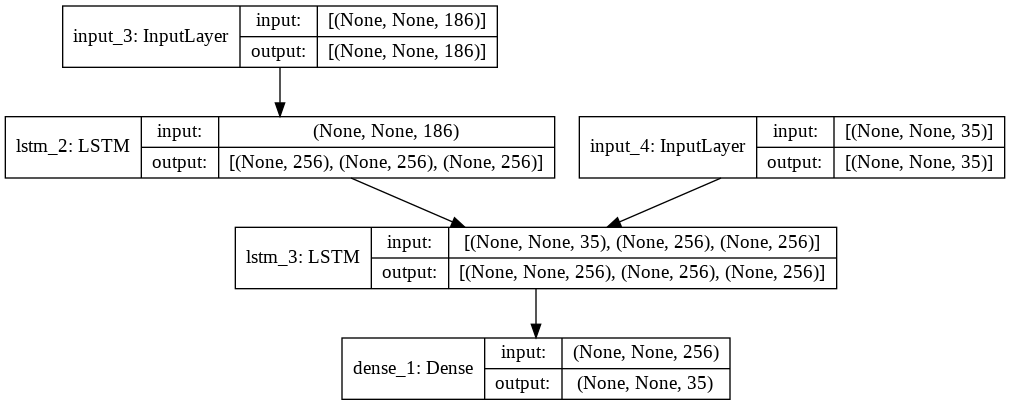

In [103]:
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

# Train

In [104]:
# Training
batch_size = 64  # Batch size for training.
epochs = 100  # Number of epochs to train for.
initial_learning_rate = 0.001

model_save_filename = "model.h5"

model.compile(
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=initial_learning_rate), 
    loss='categorical_crossentropy', 
    metrics=['accuracy'])

# Add callbacks:
# 'EarlyStopping' to stop training when the model is not enhancing anymore
# 'ModelCheckPoint' to always keep the model that has the best val_accuracy
# 'LearningRateScheduler' to decay lr 
earlystopping_cb = EarlyStopping(
    monitor="val_accuracy",
    mode="max",
    verbose=1,
    patience=10, 
    restore_best_weights=True)

mdlcheckpoint_cb = ModelCheckpoint(
    model_save_filename, 
    monitor="val_accuracy", 
    mode="max",
    verbose=1,
    save_best_only=True
)

decay = initial_learning_rate / epochs
def lr_time_based_decay(epoch, lr):
    return lr * 1 / (1 + decay * epoch)
lrscheduler_cb = tf.keras.callbacks.LearningRateScheduler(lr_time_based_decay)

history = model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=batch_size, epochs=epochs,  validation_split=0.2, 
          callbacks=[earlystopping_cb, mdlcheckpoint_cb, lrscheduler_cb])

Epoch 1/100
349/349 [==============================] - 12s 24ms/step - loss: 0.6011 - accuracy: 0.0416 - val_loss: 0.4946 - val_accuracy: 0.0405

Epoch 00001: val_accuracy improved from -inf to 0.04051, saving model to model.h5
Epoch 2/100
349/349 [==============================] - 7s 20ms/step - loss: 0.5695 - accuracy: 0.0494 - val_loss: 0.4804 - val_accuracy: 0.0464

Epoch 00002: val_accuracy improved from 0.04051 to 0.04639, saving model to model.h5
Epoch 3/100
349/349 [==============================] - 7s 20ms/step - loss: 0.5456 - accuracy: 0.0551 - val_loss: 0.4687 - val_accuracy: 0.0494

Epoch 00003: val_accuracy improved from 0.04639 to 0.04938, saving model to model.h5
Epoch 4/100
349/349 [==============================] - 7s 20ms/step - loss: 0.5286 - accuracy: 0.0596 - val_loss: 0.4728 - val_accuracy: 0.0500

Epoch 00004: val_accuracy improved from 0.04938 to 0.04996, saving model to model.h5
Epoch 5/100
349/349 [==============================] - 7s 20ms/step - loss: 0.5099

In [105]:
# list all data in history
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


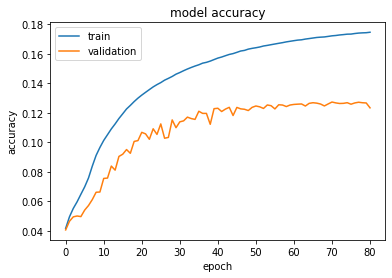

In [106]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

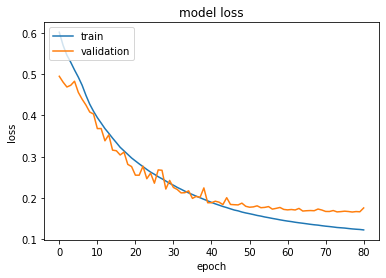

In [107]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [108]:
%ls -ltr

total 243280
-rw------- 1 root root   3898148 Sep 14 19:57 affidavits.csv
-rw------- 1 root root    813709 Sep 14 22:38 players_with_hindi_names.json
-rw------- 1 root root   6128992 Sep 19 21:17 model_v1.h5
-rw------- 1 root root   1326377 Sep 20 22:52 hi.translit.sampled.train.tsv
-rw------- 1 root root    282545 Sep 27 23:55 Transliterate_v2.ipynb
-rw------- 1 root root    128062 Sep 28 06:22 hi.translit.sampled.test.tsv
-rw------- 1 root root 230330576 Sep 29 00:55 manual_saved_model.h5
-rw------- 1 root root     32461 Sep 29 21:22 model_plot_dec.png
-rw------- 1 root root     37958 Oct  4 13:45 model.png
-rw------- 1 root root   6137184 Oct  4 13:54 model.h5


In [109]:
!du -sh model.h5

5.9M	model.h5


# Inference

In [110]:
# Restore the model and construct the encoder and decoder.
model_save_filename = "model.h5"
model = load_model(model_save_filename)
# model = load_model("model_v1.h5")

In [111]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, None, 186)]  0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, None, 35)]   0                                            
__________________________________________________________________________________________________
lstm_2 (LSTM)                   [(None, 256), (None, 453632      input_3[0][0]                    
__________________________________________________________________________________________________
lstm_3 (LSTM)                   [(None, None, 256),  299008      input_4[0][0]                    
                                                                 lstm_2[0][1]               

In [112]:
model.layers[1]

In [113]:
# Predictions
encoder_inputs = model.input[0]  # input_1
encoder_outputs, state_h_enc, state_c_enc = model.layers[2].output  # lstm_1
encoder_states = [state_h_enc, state_c_enc]

encoder_model = Model(encoder_inputs, encoder_states)

decoder_inputs = model.input[1]  # input_2

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_lstm = model.layers[3] # lstm_2
decoder_outputs, state_h_dec, state_c_dec = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs
)

decoder_states = [state_h_dec, state_c_dec]

decoder_dense = model.layers[-1]
decoder_outputs = decoder_dense(decoder_outputs)

decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states
)

In [114]:
# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict((i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict((i, char) for char, i in target_token_index.items())

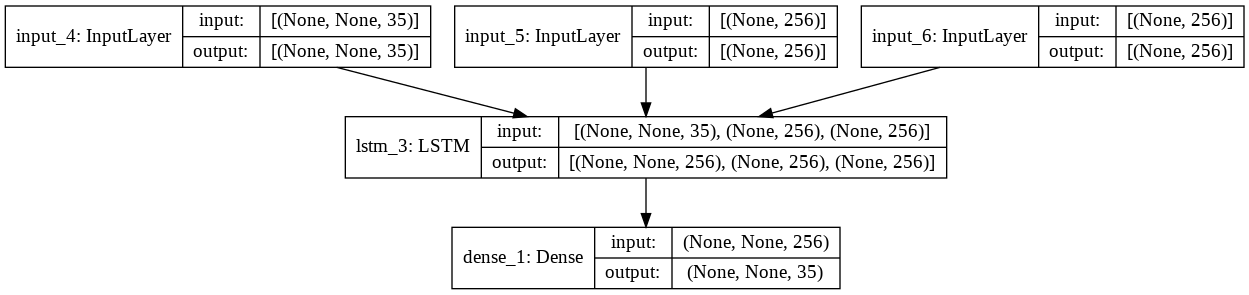

In [115]:
tf.keras.utils.plot_model(decoder_model, to_file='model_plot_dec.png', show_shapes=True, show_layer_names=True)

In [116]:
def predict_target(input_string):
  # convert for encoding 
  input_data = np.zeros((1, max_encoder_seq_length, num_encoder_tokens), dtype='float32')
  for t, char in enumerate(input_string):
    input_data[0, t, input_token_index[char]] = 1.

  # Encode the input as state vectors.
  states_value = encoder_model(input_data)

   # Generate empty target sequence of length 1.
  target_seq = np.zeros((1, 1, num_decoder_tokens), dtype='float32')
  # Populate the first character of target sequence with the start character.
  target_seq[0, 0, target_token_index['^']] = 1.0

  stop_condition = False
  decoded_sentence = ""

  while True:
    output_tokens, d_h, d_c = decoder_model.predict([target_seq] + states_value)
    # Sample a token
    sampled_token_index = np.argmax(output_tokens[0, -1, :])
    sampled_char = reverse_target_char_index[sampled_token_index]

    # Exit condition: either hit max length
    # or find stop character.
    if sampled_char == "$" or len(decoded_sentence) > max_decoder_seq_length:
      break
      
    decoded_sentence += sampled_char

    # Update the target sequence (of length 1).
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    target_seq[0, 0, sampled_token_index] = 1.0

    # Update states
    states_value = [d_h, d_c]
  return decoded_sentence

In [120]:
test_input = 'राजशेखर'
predicted_string = predict_target(test_input)
predicted_string

'rajasekha'

In [121]:
test_input = 'गौरव'
predicted_string = predict_target(test_input)
predicted_string

'gaurav'

In [122]:
test_input = 'सूद'
predicted_string = predict_target(test_input)
predicted_string

'sus'

In [123]:
dakshina_test_df = pd.read_csv('hi.translit.sampled.test.tsv', sep='\t', names=["hindi", "english", "freq"])

In [124]:
dakshina_test_df.head()

,hindi,english,freq
0,अंक,ank,5
1,अंक,anka,1
2,अंकित,ankit,3
3,अंकों,anakon,1
4,अंकों,ankhon,1


In [125]:
dakshina_test_df.style.hide_index()
def test_compare(x):
  print(f"{x['hindi']} :  actual - {x['english']}, predicted - {predict_target(x['hindi'])}")
dakshina_test_df.sample(10).apply(lambda x: test_compare(x), axis=1).to_string(index=False)

लौरेंस :  actual - laurense, predicted - laurense
इलाइची :  actual - ilayachi, predicted - ilaichi
लपेटने :  actual - lapetne, predicted - lapeetne
पल्मोनरी :  actual - palmonari, predicted - palmonain
छवी :  actual - chhavi, predicted - chhai
जूड :  actual - jood, predicted - jud
उलटे :  actual - ulte, predicted - ulte
विभाजक :  actual - vibhajak, predicted - bivhakaj
अगवाई :  actual - agavai, predicted - agavai
जयललिता :  actual - jayalalitaa, predicted - jayllita


' None\n None\n None\n None\n None\n None\n None\n None\n None\n None'

In [137]:
from tqdm import tqdm
tqdm.pandas()

dakshina_test_df.style.hide_index()
predicted = []
dakshina_test_df.progress_apply(lambda x: predicted.append(predict_target(x['hindi'])), axis=1)

100%|██████████| 4502/4502 [29:29<00:00,  2.54it/s]


0       None
1       None
2       None
3       None
4       None
        ... 
4497    None
4498    None
4499    None
4500    None
4501    None
Length: 4502, dtype: object

In [139]:
dakshina_test_df['predicted'] = predicted
dakshina_test_df.head()

,hindi,english,freq,predicted
0,अंक,ank,5,ank
1,अंक,anka,1,ank
2,अंकित,ankit,3,ankit
3,अंकों,anakon,1,ankon
4,अंकों,ankhon,1,ankon


In [140]:
test_accuracy = dakshina_test_df[dakshina_test_df['predicted'] == dakshina_test_df['english']]

In [141]:
test_accuracy.shape[0]/dakshina_test_df.shape[0]

0.2614393602843181

In [148]:
def edit_distance(s1, s2):
  t1 = tf.sparse.from_dense(tf.expand_dims(tf.strings.bytes_split(s1), axis=0))
  t2 = tf.sparse.from_dense(tf.expand_dims(tf.strings.bytes_split(s2), axis=0))
  distance = tf.edit_distance(t1, t2)
  return distance[0].numpy()

edit_dist = []

dakshina_test_df.progress_apply(lambda x: edit_dist.append(edit_distance(x['predicted'], x['english'])), axis=1)

100%|██████████| 4502/4502 [01:04<00:00, 70.29it/s]


0       None
1       None
2       None
3       None
4       None
        ... 
4497    None
4498    None
4499    None
4500    None
4501    None
Length: 4502, dtype: object

In [149]:
dakshina_test_df['edit_distance'] = edit_dist
dakshina_test_df.head()

,hindi,english,freq,predicted,edit_distance
0,अंक,ank,5,ank,0.000000
1,अंक,anka,1,ank,0.250000
2,अंकित,ankit,3,ankit,0.000000
3,अंकों,anakon,1,ankon,0.166667
4,अंकों,ankhon,1,ankon,0.166667


In [151]:
dakshina_test_df.to_csv('dakshina_acc_results.csv',index=False)

(array([1.177e+03, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 2.000e+00, 3.000e+00, 2.100e+01, 5.400e+01, 1.040e+02,
        1.610e+02, 0.000e+00, 2.440e+02, 2.000e+00, 2.930e+02, 0.000e+00,
        2.800e+01, 0.000e+00, 3.150e+02, 2.000e+00, 1.120e+02, 4.000e+00,
        0.000e+00, 3.010e+02, 0.000e+00, 2.800e+01, 2.070e+02, 0.000e+00,
        5.600e+01, 3.000e+00, 0.000e+00, 3.410e+02, 0.000e+00, 2.000e+00,
        2.000e+01, 9.500e+01, 5.000e+00, 0.000e+00, 1.890e+02, 1.100e+01,
        9.400e+01, 0.000e+00, 4.500e+01, 8.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 2.560e+02, 0.000e+00, 0.000e+00, 3.000e+00,
        4.000e+00, 1.600e+01, 0.000e+00, 4.400e+01, 3.000e+00, 0.000e+00,
        5.800e+01, 1.000e+00, 2.500e+01, 4.000e+00, 1.000e+00, 0.000e+00,
        6.800e+01, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 1.300e+01,
        0.000e+00, 0.000e+00, 0.000e+00, 3.100e+01, 0.000e+00, 5.000e+00,
        0.000e+00, 0.000e+00, 1.400e+0

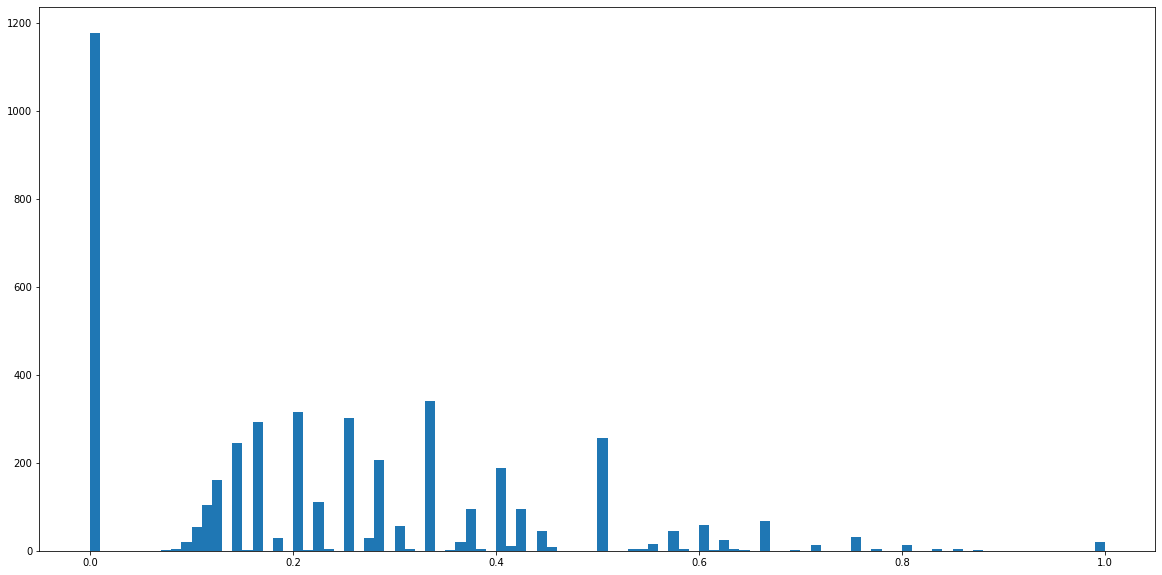

In [159]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.hist(edit_dist, bins=np.arange(min(edit_dist), max(edit_dist)+0.01, step=0.01))

In [162]:
dakshina_test_df[dakshina_test_df['edit_distance'] >= 0.9]

,hindi,english,freq,predicted,edit_distance
380,इआन,eon,2,ani,1.0
422,ईए,ea,2,an,1.0
423,ईए,ia,1,an,1.0
559,एबट,ebt,1,ate,1.0
564,एमटेक,mtake,3,ameter,1.0
608,ऐंठ,end,1,anth,1.0
616,ऐल,el,1,ali,1.0
1320,ज़ी,zee,3,ji,1.0
1366,जीआर,gr,3,ne,1.0
1367,जीएम,gm,3,j,1.0


In [163]:
dakshina_test_df[dakshina_test_df['edit_distance'] == 0.0]

,hindi,english,freq,predicted,edit_distance
0,अंक,ank,5,ank,0.0
2,अंकित,ankit,3,ankit,0.0
5,अंकों,ankon,2,ankon,0.0
7,अंकोर,ankor,2,ankor,0.0
10,अंग्रज़ी,angraji,1,angraji,0.0
...,...,...,...,...,...
4478,हुईं,huin,2,huin,0.0
4487,हैतो,haito,3,haito,0.0
4488,हैरम,hairam,2,hairam,0.0
4493,हॉन्ग,hong,3,hong,0.0


In [142]:
t1 = tf.sparse.from_dense(tf.expand_dims(tf.strings.bytes_split('xyz'), axis=0))
t2 = tf.sparse.from_dense(tf.expand_dims(tf.strings.bytes_split('xy'), axis=0))

distance = tf.edit_distance(t1, t2, normalize=True)
distance[0].numpy()

0.5

In [143]:
t1 = tf.sparse.from_dense(tf.expand_dims(tf.strings.bytes_split('xyz'), axis=0))
t2 = tf.sparse.from_dense(tf.expand_dims(tf.strings.bytes_split(''), axis=0))

distance = tf.edit_distance(t1, t2, normalize=True)
distance[0].numpy()

inf

In [144]:
t1 = tf.sparse.from_dense(tf.expand_dims(tf.strings.bytes_split('yz'), axis=0))
t2 = tf.sparse.from_dense(tf.expand_dims(tf.strings.bytes_split('xyz'), axis=0))

distance = tf.edit_distance(t1, t2, normalize=True)
distance[0].numpy()

0.33333334

In [145]:
t1 = tf.sparse.from_dense(tf.expand_dims(tf.strings.bytes_split('xyz'), axis=0))
t2 = tf.sparse.from_dense(tf.expand_dims(tf.strings.bytes_split('yz'), axis=0))

distance = tf.edit_distance(t1, t2, normalize=True)
distance[0].numpy()

0.5